# Autoencoder 3D-UNET

## 1. Libraries

In [1]:
#########################################################################
# 01. Libraries

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from operator import itemgetter 
import matplotlib.pyplot as plt
import glob
import cv2
from scipy import ndimage

import tensorflow as tf
# To allocate memory dynamically
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')
tf.config.experimental.enable_mlir_graph_optimization()

from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50

import time
from Utils.utils import *

pd.set_option('display.max_colwidth', 1000)

#########################################################################

## 2. Global Variables

In [2]:
#########################################################################
# 02. Global Variables

path = '../01_Data/'
path_models = '../05_Saved_Models/'

path_train_masks = path + '/train_masks_fast_masks/'
path_test_masks = path + '/test_masks_fast_masks/'

#########################################################################

## 3. Load Data & Preprocess Data

In [3]:
#########################################################################
# 03. Load Data & Preprocess Data

df_train = pd.read_csv( path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

print(f'1.1 -> There are {df_train.Patient.unique().shape[0]} train unique patients')
print(f'1.2 -> There are {df_test.Patient.unique().shape[0]} test unique patients')

train_mask_paths = glob.glob(path_train_masks + '*')
test_mask_paths = glob.glob(path_test_masks + '*')

print(f'No. of Train Masks : {len(train_mask_paths)}')
print(f'No. of Test Masks : {len(test_mask_paths)}')
      
unique_train_patients = df_train.Patient.unique()
unique_test_patients = df_test.Patient.unique()

dict_train_patients_masks_paths = {patient: path_train_masks + patient + '/' for patient in unique_train_patients}
dict_test_patients_masks_paths = {patient: path_test_masks + patient + '/' for patient in unique_test_patients}

for patient in tqdm(dict_train_patients_masks_paths):
    if os.path.exists(dict_train_patients_masks_paths[patient]):
        list_files = os.listdir(dict_train_patients_masks_paths[patient])
        list_files = [dict_train_patients_masks_paths[patient] + file for file in list_files]
        dict_train_patients_masks_paths[patient] = list_files
    
for patient in tqdm(dict_test_patients_masks_paths):
    list_files = os.listdir(dict_test_patients_masks_paths[patient])
    list_files = [dict_test_patients_masks_paths[patient] + file for file in list_files]
    dict_test_patients_masks_paths[patient] = list_files
    

#########################################################################

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]

1.1 -> There are 176 train unique patients
1.2 -> There are 5 test unique patients
No. of Train Masks : 176
No. of Test Masks : 5


## 4. Data Generator

In [4]:
#########################################################################
# 05. Classes

## 04.1 Generator

class ImageDataGenerator(Sequence):
    
    def __init__(self, training, df, batch_size=1, num_frames_batch=32, 
                 alpha=1.0, random_window=False, center_crop=True,
                 img_size_load=(500, 500, 3), 
                 img_size_crop=(440, 440, 3)):
        super(ImageDataGenerator, self).__init__()
        self.training = training
        self.df = df
        self.batch_size = batch_size
        self.num_frames_batch = num_frames_batch
        self.alpha = alpha

        self.random_window = random_window
        self.center_crop = center_crop
        self.img_size_load = img_size_load
        self.img_size_crop = img_size_crop
        
        self.dict_train_patients_masks_paths = dict_train_patients_masks_paths
        self.dict_test_patients_masks_paths = dict_test_patients_masks_paths
        
        self.ids = list(self.df['Patient'].unique())

        self.num_steps = int(np.ceil(len(self.ids) / self.batch_size))
        self.on_epoch_end()
      
    # Number of batches in the sequence
    
    def __len__(self):
        return self.num_steps
    
    
    # Gets the batch at position index, return patient images and dict ini features
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        patient_ids = [self.ids[k] for k in indexes]
        list_scan_imgs = [decodePatientImages(patient,
                                              self.dict_train_patients_masks_paths,
                                              image_size=(self.img_size_load[0], self.img_size_load[1]), 
                                              numpy=True) 
                          for patient in patient_ids]
        patient_imgs = self.groupImages(list_scan_imgs)
        patient_imgs = self.loadImagesAugmented(patient_imgs)
        return patient_imgs, patient_imgs
    
    
    def filterSlices(self, array_imgs):
        num_patient_slices = array_imgs.shape[0]
        beta = int(self.alpha * num_patient_slices)
        if beta % 2 != 0:
            beta += 1
        if num_patient_slices > self.num_frames_batch:
            if beta > self.num_frames_batch and self.alpha < 1:
                remove = int((num_patient_slices - beta)/2)
                array_imgs = array_imgs[remove:, :, :, :]
                array_imgs = array_imgs[:-remove:, :, :]

        return array_imgs
    
    # Skip frames unniformally according to self.num_frames_batch value
    
    def frameSkipImages(self, patient_imgs):
        num_patient_slices = patient_imgs.shape[0]
        frame_skip = num_patient_slices // self.num_frames_batch
        skipped_patient_imgs = np.zeros((self.num_frames_batch, self.img_size_load[0], self.img_size_load[1], 1))
        for i in range(self.num_frames_batch):
            skipped_patient_imgs[i] = patient_imgs[i*frame_skip]    
        return skipped_patient_imgs
    
    # Select a random window of patient frames, in case its images has more frames than self.num_frame_batch 
    
    def randomWindow(self, patient_imgs):
        windowed_imgs = np.zeros((self.num_frames_batch, patient_imgs.shape[1], patient_imgs.shape[2], 1))
        num_frames = patient_imgs.shape[0]
        if num_frames < self.num_frames_batch:
            windowed_imgs[:num_frames] = patient_imgs
        else:
            random_frames = np.arange(num_frames)
            index = np.random.randint(0, num_frames - self.num_frames_batch)
            windowed_imgs[0:] = patient_imgs[index:index+self.num_frames_batch]
        return windowed_imgs
            
    
    # Convert raw frames to a fix size array -> (batch_size, num_frames_batch, img_size_crop[0], img_size_crop[1], 1)
    
    def groupImages(self, list_scan_imgs):
        grouped_imgs = []
        for patient_imgs in list_scan_imgs:
            if patient_imgs.shape[1] > self.num_frames_batch:
                patient_imgs = self.filterSlices(patient_imgs)
            if self.random_window:
                patient_imgs = self.randomWindow(patient_imgs)
            else:
                patient_imgs = self.frameSkipImages(patient_imgs)
            grouped_imgs.append(patient_imgs)
        return np.asarray(grouped_imgs)
        
    # Performs augmentation operations conserving the 3D property on the z axis
    
    def loadImagesAugmented(self, patient_imgs):

        if self.img_size_load != self.img_size_crop:
            patient_imgs = self.center3Dcropping(patient_imgs)
            if patient_imgs.shape[2] > self.img_size_crop[0] and patient_imgs.shape[3] > self.img_size_crop[1]:
                patient_imgs = self.random3DCropping(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = np.fliplr(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = np.flipud(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = patient_imgs[:, :, ::-1]
        if self.training and np.random.random() > 0.5:
            patient_imgs = patient_imgs[:, ::-1, :]
        if self.training:
            patient_rotated_imgs= []
            angle = np.random.randint(-15, 15)
            for batch in range(patient_imgs.shape[0]):
                batch_imgs_rotated = np.asarray([ndimage.rotate(patient_imgs[batch, i], angle, order=1,
                                                                reshape=False) for i in range(patient_imgs.shape[1])])
                patient_rotated_imgs.append(batch_imgs_rotated)
            patient_imgs = np.asarray(patient_rotated_imgs) 
        return patient_imgs
    
    
    #Random Cropping 3D - change x, y axis but not z
    
    def random3DCropping(self, patient_imgs):
        w, h = self.img_size_crop[0], self.img_size_crop[1]
        x = np.random.randint(0, patient_imgs.shape[2] - w)
        y = np.random.randint(0, patient_imgs.shape[2] - h)
        patient_crop_imgs = patient_imgs[:, :, y:y+h, x:x+w]
        return patient_crop_imgs
    
    # Center 3D Cropping
    
    def center3Dcropping(self, patient_imgs):
        w, h = patient_imgs.shape[2] - 20, patient_imgs.shape[3] - 20
        img_height, img_width = patient_imgs.shape[2], patient_imgs.shape[3]
        left, right = (img_width - w) / 2, (img_width + w) / 2
        top, bottom = (img_height - h) / 2, (img_height + h) / 2
        left, top = round(max(0, left)), round(max(0, top))
        right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))
        patient_crop_imgs = patient_imgs[:, :, top:bottom, left:right]
        return patient_crop_imgs
    
    # We shuffle the data at the end of each epoch
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        np.random.shuffle(self.indexes)
        
        
    def getOnePatient(self, patient_id):
        list_scan_imgs = [decodePatientImages(patient_id,
                                              self.dict_train_patients_masks_paths,
                                              image_size=(self.img_size_load[0], self.img_size_load[1]),
                                              numpy=True)] 
        patient_imgs = self.groupImages(list_scan_imgs)
        patient_imgs = self.loadImagesAugmented(patient_imgs)
        return patient_imgs, patient_imgs
    

## 5. Model

In [8]:
#########################################################################
# 06. Model

def unet3d(input_shape=(None, None, None, 1)):
    data_format = 'channels_last'
    input_im = layers.Input(shape=input_shape)
    
    avg_input = layers.AveragePooling3D((2, 1, 1), data_format=data_format)(input_im)
    
    conv1b = layers.Conv3D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4), 
                           data_format=data_format)(avg_input)
    batch_norm1b = layers.BatchNormalization()(conv1b)
    activ1b = layers.Activation('relu')(batch_norm1b)
    maxpool1 = layers.MaxPooling3D((2, 2, 2), data_format=data_format)(activ1b)
    
    conv2a = layers.Conv3D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(maxpool1)
    batch_norm2a = layers.BatchNormalization()(conv2a)
    activ2a = layers.Activation('relu')(batch_norm2a)
    conv2b = layers.Conv3D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(activ2a)
    batch_norm2b = layers.BatchNormalization()(conv2b)
    activ2b = layers.Activation('relu')(batch_norm2b)
    maxpool2 = layers.MaxPooling3D((2, 2, 2), data_format=data_format)(activ2b)
    
    conv3a = layers.Conv3D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(maxpool2)
    batch_norm3a = layers.BatchNormalization()(conv3a)
    activ3a = layers.Activation('relu')(batch_norm3a)
    conv3b = layers.Conv3D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(activ3a)
    batch_norm3b = layers.BatchNormalization()(conv3b)
    activ3b = layers.Activation('relu')(batch_norm3b)
    maxpool3 = layers.MaxPooling3D((2, 2, 2), data_format=data_format)(activ3b)
    
    conv4b = layers.Conv3D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(maxpool3)
    batch_norm4b = layers.BatchNormalization()(conv4b)
    activ4b = layers.Activation('relu')(batch_norm4b)
    up_conv4b = layers.UpSampling3D((2, 2, 2), data_format=data_format)(activ4b)
    
    concat1 = layers.concatenate([up_conv4b, activ3b])
    
    conv5a = layers.Conv3D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(concat1)
    batch_norm5a = layers.BatchNormalization()(conv5a)
    activ5a = layers.Activation('relu')(batch_norm5a)
    conv5b = layers.Conv3D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(activ5a)
    batch_norm5b = layers.BatchNormalization()(conv5b)
    activ5b = layers.Activation('relu')(batch_norm5b)
    up_conv5b = layers.UpSampling3D((2, 2, 2), data_format=data_format)(activ5b)
    
    concat2 = layers.concatenate([up_conv5b, activ2b])
    
    conv6a = layers.Conv3D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(concat2)
    batch_norm6a = layers.BatchNormalization()(conv6a)
    activ6a = layers.Activation('relu')(batch_norm6a)
    conv6b = layers.Conv3D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(activ6a)
    batch_norm6b = layers.BatchNormalization()(conv6b)
    activ6b = layers.Activation('relu')(batch_norm6b)
    up_conv6b = layers.UpSampling3D((2, 2, 2), data_format=data_format)(activ6b)
    
    concat3 = layers.concatenate([up_conv6b, activ1b])
    
    conv7b = layers.Conv3D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                          data_format=data_format)(concat3)
    batch_norm7b = layers.BatchNormalization()(conv7b)
    activ7b = layers.Activation('relu')(batch_norm7b)
    
    up_conv_out = layers.UpSampling3D((2, 1, 1), data_format=data_format)(activ7b)
    
    conv_out = layers.Conv3D(filters=1, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4),
                            data_format=data_format)(up_conv_out)
    batch_norm_out = layers.BatchNormalization()(conv_out)
    activ_out = layers.Activation('relu')(batch_norm_out)
    
    model = models.Model(inputs=input_im, outputs=activ_out, name='UNET3D')
    encoder_model = models.Model(inputs=input_im, outputs=activ4b, name='encoder_UNET3D')

    return model, encoder_model

#########################################################################

In [9]:
# img_size_load=(200, 200, 1)
# img_size_crop=(160, 160, 1)
# num_frames_batch = 32
# alpha = 0.9
# batch_size = 1

# tf.keras.backend.clear_session()

# df_X_train, df_X_val = getTrainValidation(df_train, df_test)

# X_train_img_generator = ImageDataGenerator(
#                              training=True, df=df_X_train,
#                              batch_size=batch_size, num_frames_batch=num_frames_batch, 
#                              alpha=alpha, random_window=True, center_crop=True,
#                              img_size_load=img_size_load, img_size_crop=img_size_crop)

# for batch in X_train_img_generator:
#     break
    
# print(batch[0].shape)
# patient_imgs = batch[0][0]
# for i in range(patient_imgs.shape[0]):
#     plt.imshow(patient_imgs[i].squeeze(), 'gray', vmin=0,vmax=1)
#     plt.show()

## 6. Model Training

Epoch 1/10
171/171 [==============================] - 131s 768ms/step - loss: 0.0862 - val_loss: 0.0632
Epoch 2/10
171/171 [==============================] - 99s 582ms/step - loss: 0.0397 - val_loss: 0.0365
Epoch 3/10
171/171 [==============================] - 99s 581ms/step - loss: 0.0224 - val_loss: 0.0187
Epoch 4/10
171/171 [==============================] - 99s 582ms/step - loss: 0.0125 - val_loss: 0.0213
Epoch 5/10
171/171 [==============================] - 99s 581ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 6/10
171/171 [==============================] - 100s 583ms/step - loss: 0.0167 - val_loss: 0.0122
Epoch 7/10
171/171 [==============================] - 100s 582ms/step - loss: 0.0086 - val_loss: 0.0060
Epoch 8/10
171/171 [==============================] - 100s 583ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 9/10
171/171 [==============================] - 99s 582ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/10
171/171 [==============================] - 100s 582ms/ste

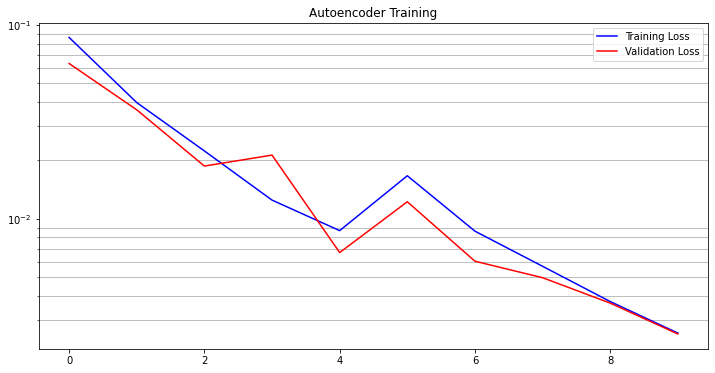

In [11]:
#########################################################################
# 07. Model Training

img_size_load=(240, 240, 1)
img_size_crop=(200, 200, 1)
num_frames_batch = 32
train_alpha = 0.9
val_alpha = 0.8
batch_size = 1

tf.keras.backend.clear_session()

df_X_train, df_X_val = getTrainValidation(df_train, df_test)


X_train_img_generator = ImageDataGenerator(
                             training=True, df=df_X_train,
                             batch_size=batch_size, num_frames_batch=num_frames_batch, 
                             alpha=train_alpha, random_window=True, center_crop=True,
                             img_size_load=img_size_load, img_size_crop=img_size_crop)

X_val_img_generator = ImageDataGenerator(
                             training=False, df=df_X_val,
                             batch_size=1, num_frames_batch=num_frames_batch, 
                             alpha=val_alpha, random_window=True, center_crop=True,
                             img_size_load=img_size_load, img_size_crop=img_size_crop)

# autoencoder_3d, encoder = unet3d(input_shape=(32, 160, 160, 1))
autoencoder_3d, encoder = unet3d(input_shape=(None, None, None, 1))

optimizer = optimizers.Adam(learning_rate=1e-3)
optimizer = tf.train.experimental.enable_mixed_precision_graph_rewrite(optimizer)

autoencoder_3d.compile(loss=tf.keras.losses.MeanSquaredError(), 
                       optimizer=optimizer)

# print(autoencoder_3d.summary(120))

history = autoencoder_3d.fit(
    X_train_img_generator,
    validation_data=X_val_img_generator,
    epochs=10,
    verbose=1
) 

plotTrainHistory(history.history, title='Autoencoder Training', scale=True)
    
tf.keras.models.save_model(model=encoder, filepath=path_models + 'encoder_unet3d_v0.2.h5', include_optimizer=False)

#########################################################################

## 7. Reconstruction

Patient: ID00351637202289476567312
0
Original


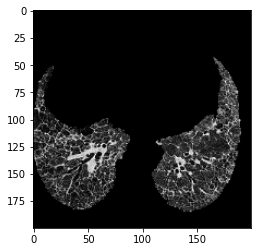

Reconstructed


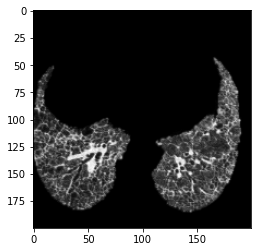

1
Original


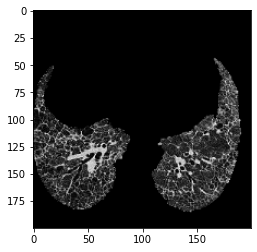

Reconstructed


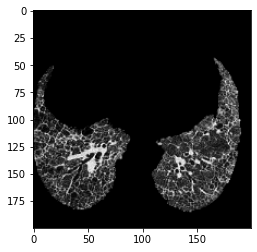

2
Original


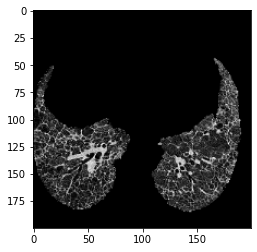

Reconstructed


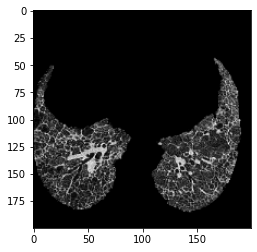

3
Original


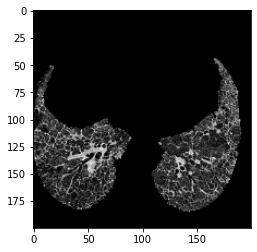

Reconstructed


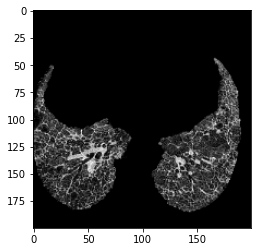

4
Original


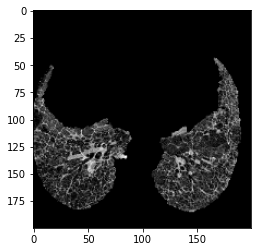

Reconstructed


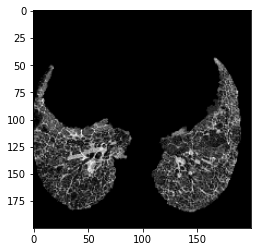

5
Original


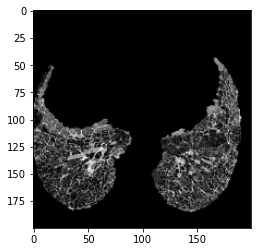

Reconstructed


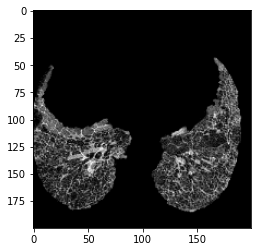

6
Original


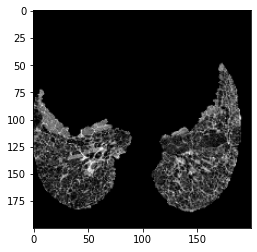

Reconstructed


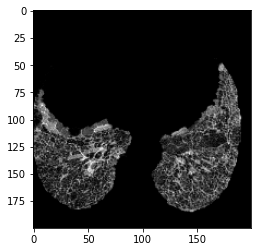

7
Original


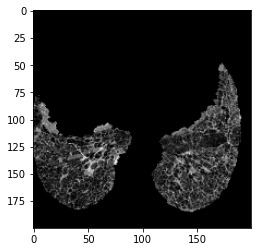

Reconstructed


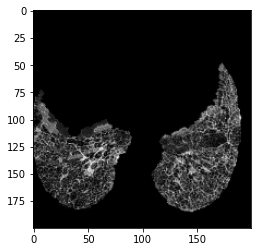

8
Original


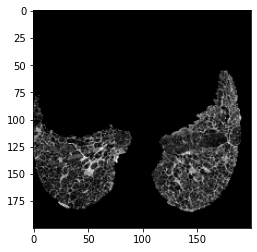

Reconstructed


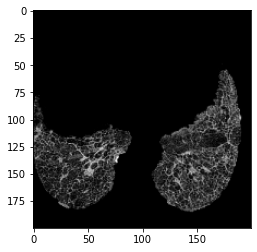

9
Original


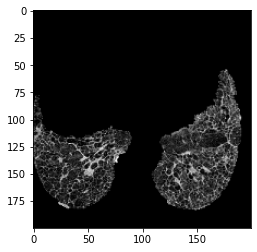

Reconstructed


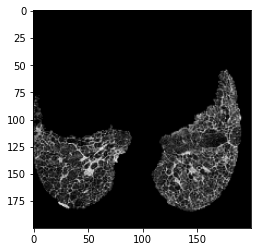

10
Original


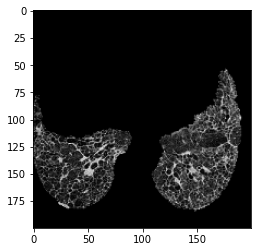

Reconstructed


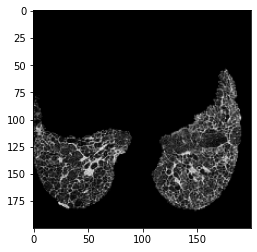

11
Original


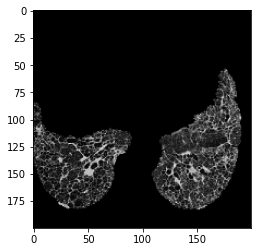

Reconstructed


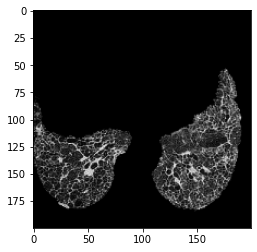

12
Original


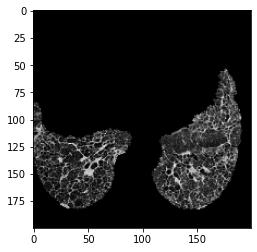

Reconstructed


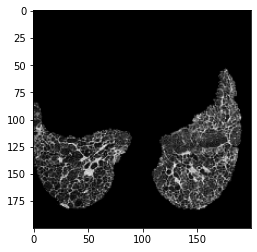

13
Original


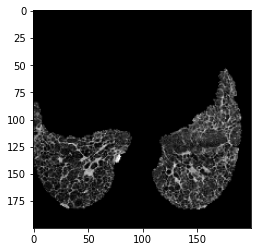

Reconstructed


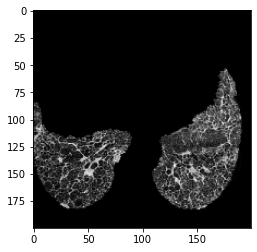

14
Original


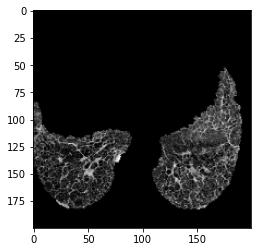

Reconstructed


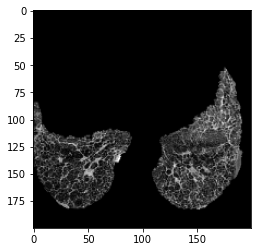

15
Original


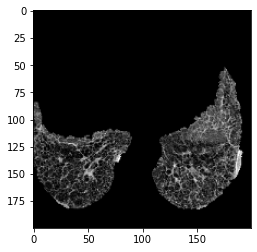

Reconstructed


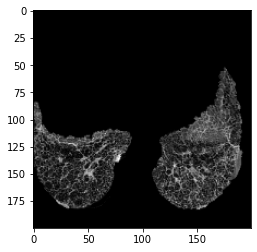

16
Original


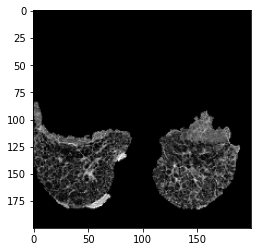

Reconstructed


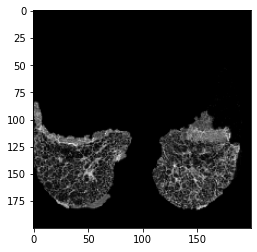

17
Original


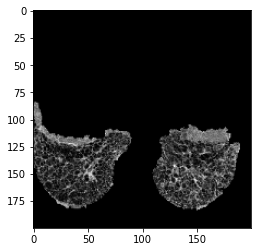

Reconstructed


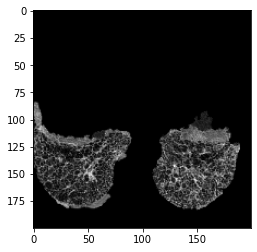

18
Original


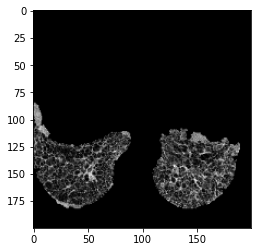

Reconstructed


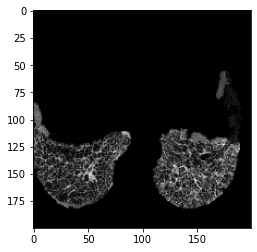

19
Original


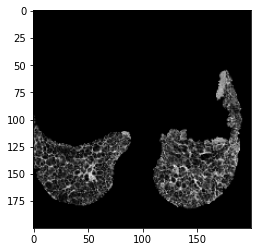

Reconstructed


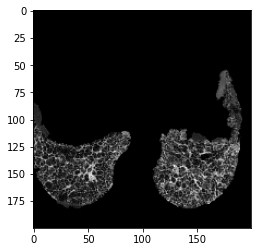

20
Original


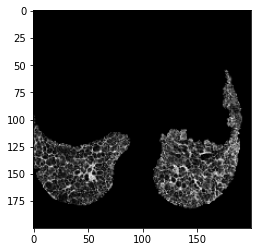

Reconstructed


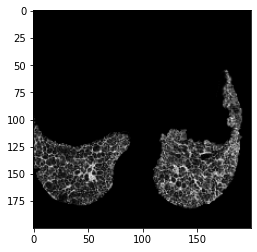

21
Original


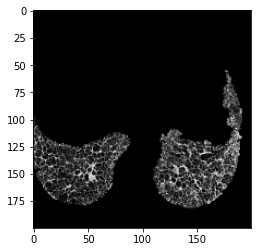

Reconstructed


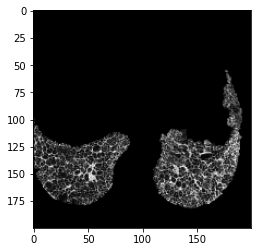

22
Original


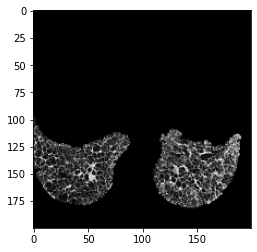

Reconstructed


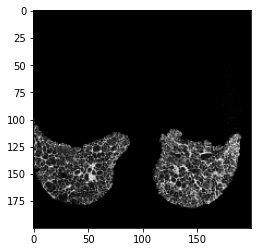

23
Original


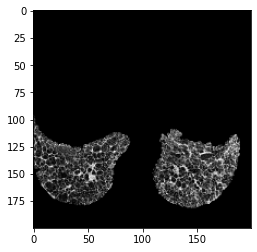

Reconstructed


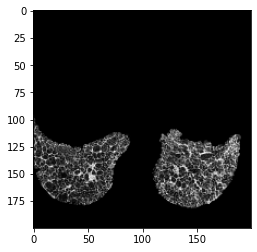

24
Original


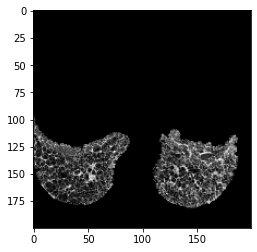

Reconstructed


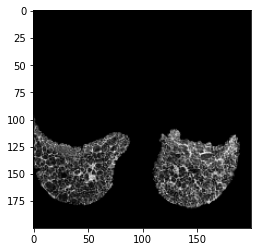

25
Original


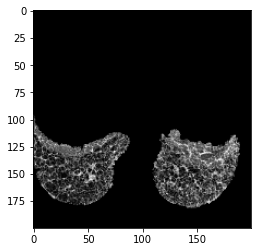

Reconstructed


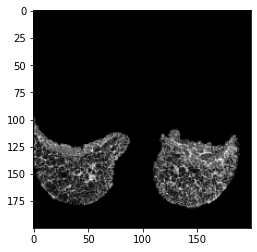

26
Original


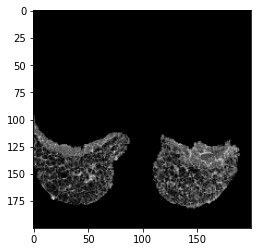

Reconstructed


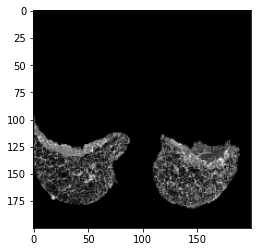

27
Original


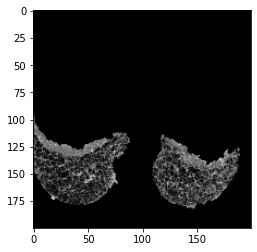

Reconstructed


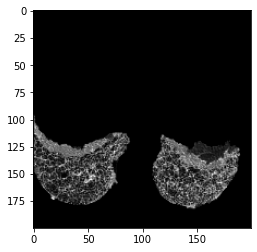

28
Original


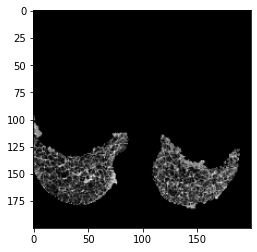

Reconstructed


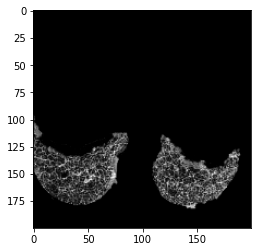

29
Original


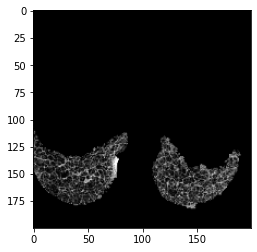

Reconstructed


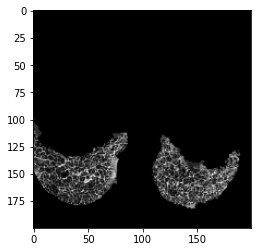

30
Original


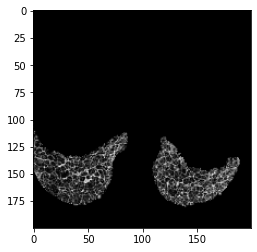

Reconstructed


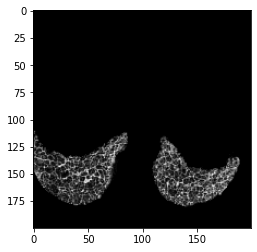

31
Original


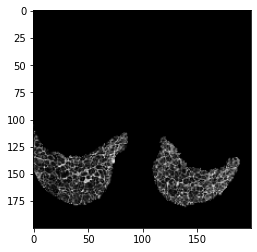

Reconstructed


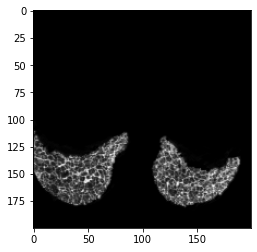

In [13]:
#########################################################################
# 08. Imgs Reconstruction

patient = np.random.choice(list(df_train['Patient'].unique()))
print(f'Patient: {patient}')

patient_imgs = X_val_img_generator.getOnePatient(patient)[0]
patient_imgs_reconstrcuted = autoencoder_3d.predict(patient_imgs)

for i in range(patient_imgs.shape[1]):
    print(i)
    print('Original')
    plt.imshow(patient_imgs[0, i].squeeze(), 'gray')
    plt.show()
    print('Reconstructed')
    plt.imshow(patient_imgs_reconstrcuted[0, i].squeeze(), 'gray')
    plt.show()
    print('==='*20)
    
#########################################################################